In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp
import scipy.stats as stats
import scipy.optimize as opt
import imageio
import utils
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline
%load_ext autoreload
%autoreload 2

xrange = (-2, 2)
yrange = (-2, 2)
interp_method = "nearest"

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.LinearMean(input_size=2)
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

res = 150
xs = torch.linspace(*xrange, res)
ys = torch.linspace(*yrange, res)
xv, yv = torch.meshgrid(xs, ys, indexing="ij")

gt_x = torch.cat((
    xv.contiguous().view(xv.numel(), 1),
    yv.contiguous().view(yv.numel(), 1)),
    dim=1
).to("cuda")

gt_likelihood = gpytorch.likelihoods.GaussianLikelihood().to("cuda")
gt_model = ExactGPModel(gt_x, gt_x*0, gt_likelihood).to("cuda")

gt_model.likelihood.noise = 0.001
gt_model.covar_module.base_kernel.lengthscale = (0.5, 10.)
gt_model.mean_module.bias = torch.nn.Parameter([0])
gt_model.mean_module.weights = torch.nn.parameter([0., 1.])

gt_likelihood.eval()
gt_model.eval()


with torch.no_grad(), gpytorch.settings.prior_mode(), gpytorch.settings.fast_computations(solves=False, covar_root_decomposition=False, log_prob=False):
    predictions = gt_likelihood(gt_model(gt_x))
    real=predictions.sample().detach().cpu().numpy().reshape(res, res)


real_interp = interp.RegularGridInterpolator((xs, ys), real, "linear") 

def mean(x,y):
    x = np.clip(x, *xrange)
    y = np.clip(y, *yrange)
    return real_interp((x,y))

fig, axs = plt.subplots(1,1, figsize=(4,4))
axs = np.atleast_1d(axs)
axs[0].set_title("high res mean")
utils.plot_realization(mean(xv,yv), axs[0], xv, yv)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


AttributeError: 'int' object has no attribute 'detach'

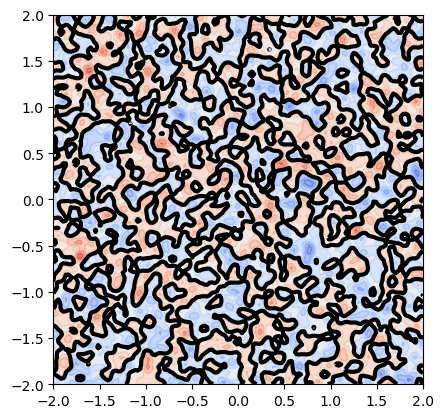

torch.float32 torch.float32


KeyError: "param 'initial_lr' is not specified in param_groups[0] when resuming an optimizer"

In [2]:
xv, yv = torch.meshgrid(torch.linspace(*xrange, 150), torch.linspace(*yrange, 150), indexing="ij")

train_x = torch.cat((
    xv.contiguous().view(xv.numel(), 1),
    yv.contiguous().view(yv.numel(), 1)),
    dim=1
)

# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.from_numpy(mean(train_x[:, 0], train_x[:, 1])).to(dtype=torch.float32).to("cuda")
train_x = train_x.to("cuda")

utils.plot_realization(mean(xv, yv), plt.gca(), xv, yv)
plt.show()

print(train_x.dtype, train_y.dtype)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood().to("cuda")
model = ExactGPModel(train_x, train_y*0, likelihood).to("cuda")

training_iter = 500
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.2)  # Includes GaussianLikelihood parameters
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

with gpytorch.settings.prior_mode():
    for i in range(training_iter):
        def closure():
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from model
            output = model(train_x)
            # Calc loss and backprop gradients
            loss = -mll(output, train_y)
            loss.backward()
            return loss


        # print('Iter %d/%d - Loss: %.3f  Variance: %.3f lengthscale: %.3f,%.3f  noise: %.3f' % (
        #     i + 1, training_iter, loss.item(),
        #     model.covar_module.outputscale.item(),
        #     model.covar_module.base_kernel.lengthscale[0,0].item(),
        #     model.covar_module.base_kernel.lengthscale[0,1].item(),
        #     model.likelihood.noise.item()
        # ))
        # print('Iter %d/%d - Loss: %.3f mean: %.3f lengthscale: %.3f  noise: %.3f' % (
        #     i + 1, training_iter, loss.item(),
        #     model.mean_module.constant.item(),
        #     model.covar_module.lengthscale.item(),
        #     model.likelihood.noise.item()
        # ))
        print('Iter %d/%d - mean: %.3f lengthscale: %.3f  noise: %.3f' % (
            i + 1, training_iter,
            model.mean_module.constant.item(),
            model.covar_module.lengthscale.item(),
            model.likelihood.noise.item()
        ))
        optimizer.step(closure)
        scheduler.step()

ls = model.covar_module.lengthscale

Parameter name: likelihood.noise_covar.raw_noise           value = -7.763619899749756
Parameter name: mean_module.raw_constant                   value = 0.007271581795066595
Parameter name: covar_module.raw_lengthscale               value = -3.050630807876587


Text(0.5, 1.0, 'Sample')

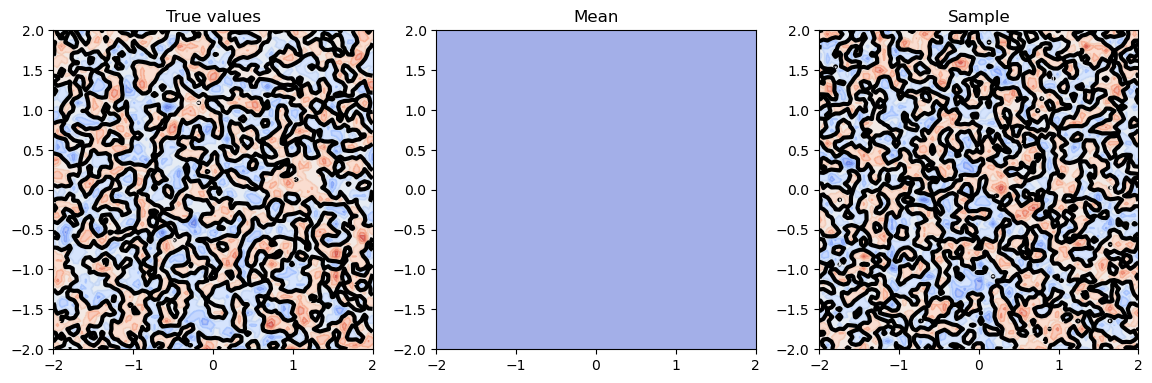

In [ ]:
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Initialize plots
fig, ax = plt.subplots(1, 3, figsize=(14, 10))

# Test points
n1, n2 = 80, 80
xv, yv = torch.meshgrid(torch.linspace(*xrange, n1), torch.linspace(*yrange, n2), indexing="ij")
xv, yv = torch.meshgrid(torch.linspace(-2,2, n1), torch.linspace(-2,2, n2), indexing="ij")
f = mean(xv, yv)

#model.covar_module.lengthscale = ls * 0.5
# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.prior_mode(), gpytorch.settings.fast_computations(log_prob=False, covar_root_decomposition=False, solves=False):
#with torch.no_grad(), gpytorch.settings.prior_mode():
    test_x = torch.stack([xv.reshape(n1*n2, 1), yv.reshape(n1*n2, 1)], -1).squeeze(1).to("cuda")
    predictions = likelihood(model(test_x))
    pred_mean = predictions.mean
    sample=predictions.sample()

extent = (xv.min(), xv.max(), yv.max(), yv.min())
utils.plot_realization(f, ax[0], xv, yv)
ax[0].set_title('True values')

utils.plot_realization(pred_mean.detach().cpu().numpy().reshape(n1, n2) + 0.01, ax[1], xv, yv)
ax[1].set_title('Mean')

utils.plot_realization(sample.detach().cpu().numpy().reshape(n1, n2), ax[2], xv, yv)
ax[2].set_title('Sample')